# Days exceedence by basin

In [1]:
import sys
sys.path.insert(1, '../scripts/')
import xarray
import yaml
import numpy as np
import pandas
import pathlib
import time
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
# load functions from my scripts file "ssm_utils"
from ssm_utils import get_nearest_node, reshape_fvcom, calc_fvcom_stat, extract_fvcom_level

In [2]:
output_dir = pathlib.Path('/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data')
graphics_directory = pathlib.Path('/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/graphics')

# Load netcdf of min daily DO on bottom level
These netcdf were output from `dev_TS_ExistRef_graphic.ipynb`

In [3]:
%%time
MinDO={}
idx=0
# loop through comparison cases and get timeseries from model output
for run_type in ['deviation','baseline']:
    print(run_type)
    xr=xarray.open_dataset(
        output_dir/f'dailyDO_tmin_bottom_{run_type}.nc'
    )
    MinDO[run_type]=xr.DailyMinBottomDO

deviation
baseline
CPU times: user 14.6 ms, sys: 29.4 ms, total: 43.9 ms
Wall time: 95.1 ms


In [4]:
MinDO[run_type].shape

(365, 16012)

# Load DO threshold information

In [5]:
with open('../etc/SSM_config.yaml', 'r') as file:
    ssm = yaml.safe_load(file)
# get shapefile path    
shp = ssm['shapefile_path']
# load shapefile into geopandas dataframe
gdf = gpd.read_file(shp)
gdf.head(1)

,node_id,Basin,uncategori,x,y,x_shp,y_shp,lat,lon,depth,included_i,DO_std,volume,area,Shape_Leng,Shape_Area,geometry
0,1249,SJF_Admiralty,None,380473.98,5365288.5,380500.860294,5.365280e+06,48.429395,-124.615801,160.628998,1,7,1.824350e+09,11357538.53,13249.778795,1.135754e+07,"POLYGON ((378570.860 5364434.875, 378213.530 5..."


In [6]:
DO_thresh = gdf['DO_std']
DO_thresh.shape

(7494,)

# Sub-sample model output with shapefile nodes
Assumption: array index = node_id -1
Why?  node_id = [1,16012], array index = [0,16012)

In [7]:
MinDO[run_type].shape

(365, 16012)

In [8]:
%%time
MinDO_basins={}
for run_type in ['deviation','baseline']:
    run_type
    MinDO_basins[run_type]=MinDO[run_type][:,gdf['node_id']-1]

CPU times: user 3.08 ms, sys: 20 µs, total: 3.1 ms
Wall time: 3.15 ms


In [9]:
MinDO_basins[run_type].shape

(365, 7494)

# Create boolean where MinDO < threshold

In [10]:
nnodes = len(DO_thresh)
ndays=365
AnoxicDays={}
# create array of DO_threshold values to determine number of days of noncompliance
DO_thresh2D = np.ones((nnodes,ndays))*np.array(DO_thresh).reshape(nnodes,1)
# (7494,365) x (7494,1) => element-wise multiplication
for run_type in ['deviation','baseline']:
    run_type
    Anoxic = MinDO_basins[run_type].transpose()<=DO_thresh2D
    AnoxicDays[run_type]=Anoxic.sum(axis=1)

In [11]:
AnoxicDays[run_type].median()

<xarray.DataArray 'DailyMinBottomDO' ()>
array(162.)

# Create pandas dataframe with Anoxic days by basin

In [12]:
gdf[['node_id','Basin']].groupby('Basin').count().index.to_list()

['Hood_Canal',
 'Main_Basin',
 'SJF_Admiralty',
 'SOG_Bays',
 'South_Sound',
 'Whidbey_Basin']

In [13]:
TotalAnoxic={}
basins = gdf[['node_id','Basin']].groupby('Basin').count().index.to_list()
for run_type in ['deviation','baseline']:
    TotalAnoxic[run_type]={}
    for basin in basins:
        TotalAnoxic[run_type][basin]=np.array(AnoxicDays[run_type])[gdf['Basin']==basin].sum()

In [14]:
pandas.DataFrame(TotalAnoxic)

,deviation,baseline
Hood_Canal,222270,220923
Main_Basin,215083,203937
SJF_Admiralty,320815,320257
SOG_Bays,199846,199058
South_Sound,185479,173016
Whidbey_Basin,157313,147070


#### The above is total days where bottom DO < threshold, by basin, with "deviation" reflecting "existing" and "baseline" as "reference"

# Calculate volume days exceedence

In [20]:
%%time
# specify variable to plot
graphic_var = 'DO'
# get correspoding model variable name, Var_10, for "DO"
ssm_var_name = ssm['var_name'][graphic_var]

for run_type in ['deviation','baseline']:
    # input netcdf filename
    index = ssm['run_index'][run_type]
    path=pathlib.Path(
        ssm['output_paths'][index])/'s_hy_base000_pnnl007_nodes.nc'
    print(path.as_posix())
    # load variable into xarray and calculate daily min.
    with xarray.open_dataset(path) as ds:
        dailyDO = reshape_fvcom(
            ds[ssm_var_name][:,:].data, 
            'days'
        ) #return (365x24xnodes)
    # calculate daily minimum (365 x nodes)
    dailyDO_tmin = calc_fvcom_stat(dailyDO, 'min', axis=1)
    # reshape to levels
    dailyDO_tmin_rshp = reshape_fvcom(dailyDO_tmin, 'levels')
    # save to file
    xr_minDO=xarray.DataArray(dailyDO_tmin_rshp, name='DailyMinDO')
    xr_minDO.to_netcdf(output_dir/f'dailyDO_24hr_min_{run_type}.nc')

/mmfs1/gscratch/ssmc/USRS/PSI/Adi/BS_WQM/2014_SSM4_WQ_exist_orig/hotstart/outputs/s_hy_base000_pnnl007_nodes.nc
8760 160120
365 160120
/mmfs1/gscratch/ssmc/USRS/PSI/Adi/BS_WQM/2014_SSM4_WQ_ref_orig/hotstart/outputs/s_hy_base000_pnnl007_nodes.nc
8760 160120
365 160120
CPU times: user 4.39 s, sys: 30 s, total: 34.4 s
Wall time: 1min 47s


In [22]:
%%time
minDailyDO={}
for run_type in ['deviation','baseline']:
    netcdf_in = output_dir/f'dailyDO_24hr_min_{run_type}.nc'
    minDailyDO[run_type]=xarray.open_dataset(netcdf_in)

CPU times: user 4.83 ms, sys: 6.1 ms, total: 10.9 ms
Wall time: 23.7 ms


In [25]:
minDailyDO[run_type].DailyMinDO.shape

(365, 16012, 10)

## Use `gdf[node_id]-1` to get array indices 

In [26]:
%%time
minDailyDO_shp={}
for run_type in ['deviation','baseline']:
    minDailyDO_shp[run_type]=minDailyDO[run_type].DailyMinDO[:,gdf['node_id']-1,:]

CPU times: user 4.56 ms, sys: 11.2 ms, total: 15.7 ms
Wall time: 72.3 ms


In [27]:
minDailyDO_shp[run_type].shape

(365, 7494, 10)

In [29]:
minDailyDO_shp[run_type]

<xarray.DataArray 'DailyMinDO' (dim_0: 365, dim_1: 7494, dim_2: 10)>
[27353100 values with dtype=float32]
Dimensions without coordinates: dim_0, dim_1, dim_2

In [31]:
minDailyDO_shp[run_type].transpose('dim_1','dim_0','dim_2').shape

(7494, 365, 10)

## Calculate days exceedence for all layers

In [51]:
DO_thresh = gdf['DO_std']
DO_thresh3D = np.ones((nnodes,ndays,10))*np.array(DO_thresh).reshape(nnodes,1,1)

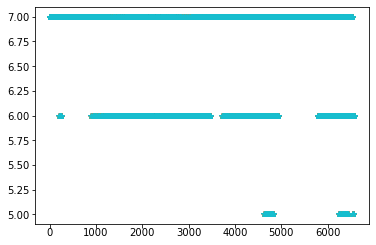

In [52]:
goodDO = DO_thresh3D>0
for depth in range(0,10):
    plt.plot(DO_thresh3D[good][:,1,depth],'*')

In [53]:
minDailyDO_shp[run_type].shape

(365, 7494, 10)

In [58]:
DO_thresh3D=DO_thresh3D.reshape(365,7494,10)

In [59]:
DO_thresh3D.shape

(365, 7494, 10)

In [65]:
%%time
nnodes = len(DO_thresh)
ndays=365
AnoxicDays={}
# create array of DO_threshold values to determine number of days of noncompliance
DO_thresh3D = np.ones((nnodes,ndays,10))*np.array(DO_thresh).reshape(nnodes,1,1)# (7494,365) x (7494,1) => element-wise multiplication
DO_thresh3D=DO_thresh3D.reshape(365,7494,10)
for run_type in ['deviation','baseline']:
    print(run_type)
    Anoxic = minDailyDO_shp[run_type]<=DO_thresh3D
    AnoxicDays[run_type]=Anoxic.sum(axis=0)

deviation
baseline
CPU times: user 362 ms, sys: 209 ms, total: 571 ms
Wall time: 1.14 s


In [63]:
minDailyDO_shp[run_type].shape

(365, 7494, 10)

In [64]:
DO_thresh3D.shape

(365, 7494, 10)

In [66]:
AnoxicDays[run_type].shape

(7494, 10)

In [67]:
TotalAnoxic={}
basins = gdf[['node_id','Basin']].groupby('Basin').count().index.to_list()
for run_type in ['deviation','baseline']:
    TotalAnoxic[run_type]={}
    for basin in basins:
        TotalAnoxic[run_type][basin]=np.array(AnoxicDays[run_type])[gdf['Basin']==basin].sum()

In [71]:
pandas.DataFrame(TotalAnoxic).rename(columns={'deviation':'existing','baseline':'reference'})

,existing,reference
Hood_Canal,1259272,1240092
Main_Basin,1135621,1088283
SJF_Admiralty,1881942,1877148
SOG_Bays,1009903,1004898
South_Sound,841102,773895
Whidbey_Basin,1141771,1083516


###  Number of "node days" with DO < DO_std anywhere in water column
- Remove "double count" across depth levels
- Multiply by volume -> volume days

In [16]:
np.array(AnoxicDays[run_type])[test].sum()

147070

In [17]:
np.array(AnoxicDays[run_type])[gdf['Basin']==basin].shape

(2067,)